In [1]:
import pandas as pd
import datetime as dt

In [2]:
online = pd.read_csv('online_orders.csv')
print(online.shape)

(68176, 9)


In [3]:
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'])
online.drop(labels=['Unnamed: 0'], axis=1, inplace=True)
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25,2.10,14286,United Kingdom
1,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20,1.45,16360,United Kingdom
2,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14,3.75,13933,United Kingdom
3,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23,2.10,17290,United Kingdom
4,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25,5.95,17663,United Kingdom


## Cohort analysis

In [4]:
# Group by CustomerID and select the InvoiceDay value
# Assign a minimum InvoiceDay value to the dataset
online['InvoiceDay'] = online['InvoiceDate']
online['CohortDay'] = online.groupby('CustomerID')['InvoiceDay'].transform('min')
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDay
0,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25,2.10,14286,United Kingdom,2011-10-25,2011-04-11
1,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20,1.45,16360,United Kingdom,2011-11-20,2011-09-12
2,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14,3.75,13933,United Kingdom,2011-07-14,2011-07-14
3,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23,2.10,17290,United Kingdom,2011-11-23,2011-11-23
4,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25,5.95,17663,United Kingdom,2011-05-25,2011-02-25


In [5]:
# CohortMonth is the month of their first transaction, aka the month they joined

def to_month(x):
    return pd.to_datetime(dt.datetime(x.year, x.month, 1))

online['InvoiceMonth'] = online['InvoiceDate'].apply(to_month)
#This is a transform function, not an aggregate function like sum() or mean()
#Thus is returns an array of the same length as online
online['CohortMonth'] = online[['CustomerID', 'InvoiceMonth']].groupby('CustomerID').transform('min')
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDay,InvoiceMonth,CohortMonth
0,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25,2.10,14286,United Kingdom,2011-10-25,2011-04-11,2011-10-01,2011-04-01
1,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20,1.45,16360,United Kingdom,2011-11-20,2011-09-12,2011-11-01,2011-09-01
2,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14,3.75,13933,United Kingdom,2011-07-14,2011-07-14,2011-07-01,2011-07-01
3,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23,2.10,17290,United Kingdom,2011-11-23,2011-11-23,2011-11-01,2011-11-01
4,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25,5.95,17663,United Kingdom,2011-05-25,2011-02-25,2011-05-01,2011-02-01


In [6]:
# Create CohortIndex which is a score of the month difference between Invoice and Cohort

def get_date_int(df, column):
    return df[column].dt.year, df[column].dt.month, df[column].dt.day

# Get the integers for date parts from the InvoiceDaycolumn
invoice_year, invoice_month, invoice_day = get_date_int(online, 'InvoiceDay')

# Get the integers for date parts from the CohortDay column
cohort_year, cohort_month, cohort_day = get_date_int(online, 'CohortDay')

# Find the difference to calculate cohort index
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
days_diff = invoice_day - cohort_day

# Extract the difference in days from all previous values
online['CohortIndex'] = years_diff*12 + months_diff + 1
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDay,InvoiceMonth,CohortMonth,CohortIndex
0,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25,2.10,14286,United Kingdom,2011-10-25,2011-04-11,2011-10-01,2011-04-01,7
1,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20,1.45,16360,United Kingdom,2011-11-20,2011-09-12,2011-11-01,2011-09-01,3
2,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14,3.75,13933,United Kingdom,2011-07-14,2011-07-14,2011-07-01,2011-07-01,1
3,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23,2.10,17290,United Kingdom,2011-11-23,2011-11-23,2011-11-01,2011-11-01,1
4,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25,5.95,17663,United Kingdom,2011-05-25,2011-02-25,2011-05-01,2011-02-01,4


In [7]:
online['CustomerID'].unique().shape

(3643,)

In [8]:
cohort_data = online.groupby(['CohortMonth', 'CohortIndex']).nunique().reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,383.0,149.0,145.0,156.0,165.0,180.0,160.0,147.0,154.0,160.0,150.0,208.0,113.0
2011-01-01,429.0,109.0,134.0,123.0,161.0,139.0,126.0,130.0,160.0,146.0,180.0,77.0,NaN
2011-02-01,352.0,67.0,67.0,94.0,97.0,85.0,91.0,98.0,100.0,113.0,36.0,NaN,NaN
2011-03-01,422.0,67.0,113.0,88.0,91.0,74.0,113.0,94.0,122.0,44.0,NaN,NaN,NaN
2011-04-01,279.0,61.0,60.0,59.0,58.0,59.0,67.0,70.0,18.0,NaN,NaN,NaN,NaN
2011-05-01,267.0,41.0,47.0,41.0,55.0,62.0,68.0,25.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,214.0,33.0,27.0,43.0,49.0,64.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,185.0,29.0,33.0,42.0,47.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,145.0,30.0,30.0,36.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cohort metrics
* Retention rate
* Mean cohort order quantity
* Mean cohort order price

In [9]:
cohort_sizes = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(3) * 100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,38.9,37.9,40.7,43.1,47.0,41.8,38.4,40.2,41.8,39.2,54.3,29.5
2011-01-01,100.0,25.4,31.2,28.7,37.5,32.4,29.4,30.3,37.3,34.0,42.0,17.9,NaN
2011-02-01,100.0,19.0,19.0,26.7,27.6,24.1,25.9,27.8,28.4,32.1,10.2,NaN,NaN
2011-03-01,100.0,15.9,26.8,20.9,21.6,17.5,26.8,22.3,28.9,10.4,NaN,NaN,NaN
2011-04-01,100.0,21.9,21.5,21.1,20.8,21.1,24.0,25.1,6.5,NaN,NaN,NaN,NaN
2011-05-01,100.0,15.4,17.6,15.4,20.6,23.2,25.5,9.4,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,15.4,12.6,20.1,22.9,29.9,8.9,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,15.7,17.8,22.7,25.4,10.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,20.7,20.7,24.8,10.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
cohort_data = online.groupby(['CohortMonth', 'CohortIndex'])['Quantity'].mean().reset_index()
cohort_mean_quantity = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Quantity')
cohort_mean_quantity.round(2)

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,12.01,13.28,11.32,13.53,13.55,11.50,9.81,12.55,14.71,12.77,15.52,11.26,14.38
2011-01-01,10.76,10.97,10.67,9.88,12.89,11.44,14.64,13.61,15.70,10.07,11.10,10.97,NaN
2011-02-01,12.71,16.48,14.93,11.54,17.47,13.20,16.49,13.22,13.37,16.10,18.30,NaN,NaN
2011-03-01,9.61,14.17,12.34,9.74,15.47,12.39,10.91,10.68,8.32,9.37,NaN,NaN,NaN
2011-04-01,9.88,10.64,11.39,11.33,11.38,7.41,9.98,9.40,6.43,NaN,NaN,NaN,NaN
2011-05-01,14.23,18.40,21.73,13.02,17.37,12.94,11.73,13.38,NaN,NaN,NaN,NaN,NaN
2011-06-01,10.35,16.06,18.44,10.80,12.45,7.20,9.72,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,10.73,16.27,9.93,11.50,6.71,6.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,10.21,7.36,6.01,5.81,5.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
cohort_data = online.groupby(['CohortMonth', 'CohortIndex'])['UnitPrice'].mean().reset_index()
cohort_mean_price = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='UnitPrice')
cohort_mean_price.round(2)

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,3.19,2.97,2.98,2.95,2.62,8.41,2.71,3.06,2.69,2.66,2.94,2.92,2.65
2011-01-01,3.17,3.26,2.84,3.09,3.01,3.05,2.90,2.56,2.74,3.00,2.54,2.21,NaN
2011-02-01,3.03,3.78,3.23,2.92,3.26,2.95,2.91,2.58,2.94,2.73,2.68,NaN,NaN
2011-03-01,3.43,3.50,3.48,2.78,2.70,2.48,2.63,2.92,2.58,2.58,NaN,NaN,NaN
2011-04-01,3.28,4.33,3.26,2.61,2.89,2.82,2.78,2.68,2.63,NaN,NaN,NaN,NaN
2011-05-01,3.33,2.86,2.60,2.70,2.56,2.41,2.77,2.45,NaN,NaN,NaN,NaN,NaN
2011-06-01,2.78,2.44,2.66,3.06,2.48,2.43,2.50,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,3.14,3.12,3.38,2.49,2.37,2.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,2.87,3.66,5.33,6.84,4.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


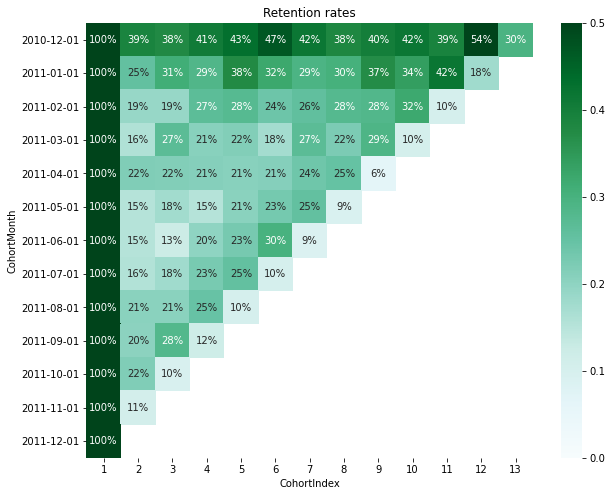

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.title('Retention rates')
sns.heatmap(data=retention, annot=True, fmt='.0%', vmin=0.0, vmax=0.5, cmap='BuGn'
            ,yticklabels=retention.index.date)
plt.show()